In [186]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib

In [187]:
DATA_FILE = Path.cwd() / "Customer_Churn_Data_Large.xlsx"
OUTPUT_CSV = Path.cwd() / "customer_churn_analysis_cleaned.csv"
SCALER_FILE = Path.cwd() / "numeric_scaler.save"
REFERENCE_DATE = None

Functions to easily load the data and the sheets

In [188]:
def read_all_sheets(xlsx_path: Path):
    xls = pd.ExcelFile(xlsx_path)
    sheets = {name: pd.read_excel(xls, name) for name in xls.sheet_names}
    return sheets

def safe_to_datetime(df, col):
    if col in df.columns:
        return pd.to_datetime(df[col], errors='coerce')
    return pd.Series(dtype='datetime64[ns]')

In [189]:
sheets = read_all_sheets(DATA_FILE)

customer_demographics = sheets.get('Customer_Demographics', pd.DataFrame())
transaction_history = sheets.get('Transaction_History', pd.DataFrame())
customer_service = sheets.get('Customer_Service', pd.DataFrame())
online_activity = sheets.get('Online_Activity', pd.DataFrame())
churn_status = sheets.get('Churn_Status', pd.DataFrame())

In [190]:
# Convert known date columns safely
transaction_history['TransactionDate'] = safe_to_datetime(transaction_history, 'TransactionDate')
customer_service['InteractionDate'] = safe_to_datetime(customer_service, 'InteractionDate')
online_activity['LastLoginDate'] = safe_to_datetime(online_activity, 'LastLoginDate')

# If no REFERENCE_DATE provided, use the latest transaction date found (keeps recency consistent)
if REFERENCE_DATE is None:
    if transaction_history['TransactionDate'].notna().any():
        REFERENCE_DATE = transaction_history['TransactionDate'].max()
    else:
        REFERENCE_DATE = pd.to_datetime('today')


In [191]:
customer_demographics.head(1)

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel
0,1,62,M,Single,Low


In [192]:
transaction_history.head(1)

,CustomerID,TransactionID,TransactionDate,AmountSpent,ProductCategory
0,1,7194,2022-03-27,416.5,Electronics


In [193]:
customer_service.head(1)

,CustomerID,InteractionID,InteractionDate,InteractionType,ResolutionStatus
0,1,6363,2022-03-31,Inquiry,Resolved


In [194]:
online_activity.head(1)

,CustomerID,LastLoginDate,LoginFrequency,ServiceUsage
0,1,2023-10-21,34,Mobile App


In [195]:
churn_status.head(1)

,CustomerID,ChurnStatus
0,1,0


In [196]:
customer_demographics.describe()

,CustomerID,Age
count,1000.000000,1000.000000
mean,500.500000,43.267000
std,288.819436,15.242311
min,1.000000,18.000000
25%,250.750000,30.000000
50%,500.500000,43.000000
75%,750.250000,56.000000
max,1000.000000,69.000000


In [197]:
customer_demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1000 non-null   int64 
 1   Age            1000 non-null   int64 
 2   Gender         1000 non-null   object
 3   MaritalStatus  1000 non-null   object
 4   IncomeLevel    1000 non-null   object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [198]:
customer_demographics.isnull().sum()

CustomerID       0
Age              0
Gender           0
MaritalStatus    0
IncomeLevel      0
dtype: int64

In [199]:
transaction_history.describe()

,CustomerID,TransactionID,TransactionDate,AmountSpent
count,5054.000000,5054.000000,5054,5054.000000
mean,501.424218,5510.538979,2022-07-01 19:25:37.158686208,250.707351
min,1.000000,1000.000000,2022-01-01 00:00:00,5.180000
25%,251.000000,3242.000000,2022-04-03 00:00:00,127.105000
50%,506.000000,5530.000000,2022-07-01 00:00:00,250.525000
75%,749.000000,7680.750000,2022-09-29 00:00:00,373.412500
max,1000.000000,9997.000000,2022-12-31 00:00:00,499.860000
std,285.172780,2582.088012,NaN,142.250838


In [200]:
transaction_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5054 entries, 0 to 5053
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerID       5054 non-null   int64         
 1   TransactionID    5054 non-null   int64         
 2   TransactionDate  5054 non-null   datetime64[ns]
 3   AmountSpent      5054 non-null   float64       
 4   ProductCategory  5054 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 197.6+ KB


In [201]:
transaction_history.isnull().sum()

CustomerID         0
TransactionID      0
TransactionDate    0
AmountSpent        0
ProductCategory    0
dtype: int64

In [202]:
transaction_history.head(1)

,CustomerID,TransactionID,TransactionDate,AmountSpent,ProductCategory
0,1,7194,2022-03-27,416.5,Electronics


In [203]:
transaction_history.nunique()

CustomerID         1000
TransactionID      3864
TransactionDate     365
AmountSpent        4797
ProductCategory       5
dtype: int64

In [204]:
customer_service.describe()

,CustomerID,InteractionID,InteractionDate
count,1002.000000,1002.000000,1002
mean,485.209581,5952.887226,2022-07-02 19:28:22.994011904
min,1.000000,2015.000000,2022-01-01 00:00:00
25%,238.250000,3991.500000,2022-04-07 00:00:00
50%,474.500000,5911.500000,2022-07-02 12:00:00
75%,735.750000,7908.250000,2022-09-30 00:00:00
max,995.000000,9997.000000,2022-12-30 00:00:00
std,287.030259,2305.819681,NaN


In [205]:
customer_service.head()

,CustomerID,InteractionID,InteractionDate,InteractionType,ResolutionStatus
0,1,6363,2022-03-31,Inquiry,Resolved
1,2,3329,2022-03-17,Inquiry,Resolved
2,3,9976,2022-08-24,Inquiry,Resolved
3,4,7354,2022-11-18,Inquiry,Resolved
4,4,5393,2022-07-03,Inquiry,Unresolved


In [206]:
customer_service.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        1002 non-null   int64         
 1   InteractionID     1002 non-null   int64         
 2   InteractionDate   1002 non-null   datetime64[ns]
 3   InteractionType   1002 non-null   object        
 4   ResolutionStatus  1002 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 39.3+ KB


In [207]:
customer_service.isnull().sum()

CustomerID          0
InteractionID       0
InteractionDate     0
InteractionType     0
ResolutionStatus    0
dtype: int64

Feature Engineering from transaction history, customer service and online activity columns

In [208]:

first_customer_transaction = (
    transaction_history.groupby('CustomerID')['TransactionDate']
    .min().reset_index().rename(columns={'TransactionDate': 'FirstTransactionDate'})
)

last_customer_transaction = (
    transaction_history.groupby('CustomerID')['TransactionDate']
    .max().reset_index().rename(columns={'TransactionDate': 'LastTransactionDate'})
)

total_amount_spent = (
    transaction_history.groupby('CustomerID')['AmountSpent']
    .sum().reset_index().rename(columns={'AmountSpent': 'TotalAmountSpent'})
)

transaction_count_per_customer = (
    transaction_history.groupby('CustomerID').size().reset_index(name='TransactionCount')
)

avg_amount_per_tx = (
    transaction_history.groupby('CustomerID')['AmountSpent']
    .mean().reset_index().rename(columns={'AmountSpent': 'AvgAmountPerTransaction'})
)

first_interaction_date = (
    customer_service.groupby('CustomerID')['InteractionDate']
    .min().reset_index().rename(columns={'InteractionDate': 'FirstInteractionDate'})
)

last_interaction_date = (
    customer_service.groupby('CustomerID')['InteractionDate']
    .max().reset_index().rename(columns={'InteractionDate': 'LastInteractionDate'})
)

total_service_interactions = (
    customer_service.groupby('CustomerID')['InteractionType']
    .count().reset_index().rename(columns={'InteractionType': 'TotalServiceInteractions'})
)

service_diversity = (
    customer_service.groupby('CustomerID')['InteractionType']
    .nunique().reset_index().rename(columns={'InteractionType': 'ServiceDiversity'})
)


last_login_df = online_activity.groupby('CustomerID')['LastLoginDate'].max().reset_index()
login_freq = None
if 'LoginFrequency' in online_activity.columns:
    # If login frequency is tracked per row, we can aggregate by mean or max depending on semantics
    login_freq = online_activity.groupby('CustomerID')['LoginFrequency'].mean().reset_index().rename(columns={'LoginFrequency': 'LoginFrequency'})

user_platform = None
if 'ServiceUsage' in online_activity.columns:
    # take the 'most frequent' or first non-null ServiceUsage per customer
    user_platform = online_activity.groupby('CustomerID')['ServiceUsage'].agg(lambda s: s.dropna().mode().iloc[0] if not s.dropna().empty else np.nan).reset_index().rename(columns={'ServiceUsage': 'ServiceUsage'})


Merging everything

In [209]:
dfs_to_merge = [
    customer_demographics,
    first_customer_transaction, last_customer_transaction,
    total_amount_spent, transaction_count_per_customer, avg_amount_per_tx,
    first_interaction_date, last_interaction_date, total_service_interactions, service_diversity,
    last_login_df, churn_status
]


if login_freq is not None:
    dfs_to_merge.append(login_freq)
if user_platform is not None:
    dfs_to_merge.append(user_platform)

# Start with demographics (so any customerIDs not in demographics will be excluded)
if customer_demographics.empty:
    all_customer_ids = pd.Index(transaction_history['CustomerID']
                                .append(customer_service['CustomerID']).append(online_activity['CustomerID']).append(churn_status['CustomerID'])
                                .dropna().unique())
    df = pd.DataFrame({'CustomerID': all_customer_ids})
else:
    df = customer_demographics.copy()

for merges in dfs_to_merge[1:]:
    df = df.merge(merges, on='CustomerID', how='left')

# Convert date columns in final DF
for col in ['FirstTransactionDate', 'LastTransactionDate', 'FirstInteractionDate', 'LastInteractionDate', 'LastLoginDate']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')


For counts: fill with 0
For numeric amounts: missing TotalAmountSpent for customers with no transactions -> 0
For date fields: 

we use business logic:

    - If a customer has no interaction dates but has LastLoginDate -> use LastLoginDate as proxy for LastInteractionDate
    - If still missing, fill with FirstTransactionDate for 'FirstInteractionDate'

In [210]:
count_cols = ['TotalServiceInteractions', 'TransactionCount', 'ServiceDiversity']
for counts in count_cols:
    if counts in df.columns:
        df[counts] = df[counts].fillna(0).astype(int)
        

if 'TotalAmountSpent' in df.columns:
    df['TotalAmountSpent'] = df['TotalAmountSpent'].fillna(0)

if 'AvgAmountPerTransaction' in df.columns:
    df['AvgAmountPerTransaction'] = df['AvgAmountPerTransaction'].fillna(0)

if 'LastInteractionDate' in df.columns and 'LastLoginDate' in df.columns:
    df['LastInteractionDate'] = df['LastInteractionDate'].fillna(df['LastLoginDate'])

if 'FirstInteractionDate' in df.columns and 'FirstTransactionDate' in df.columns:
    df['FirstInteractionDate'] = df['FirstInteractionDate'].fillna(df['FirstTransactionDate'])


Adding additional features: recency, tenure, days since last login

In [211]:
df['RecencyDays'] = (REFERENCE_DATE - df['LastTransactionDate']).dt.days
df['RecencyDays'] = df['RecencyDays'].fillna((REFERENCE_DATE - df['FirstTransactionDate']).dt.days)  # fallback
df['RecencyDays'] = df['RecencyDays'].fillna((REFERENCE_DATE - df['LastLoginDate']).dt.days)  # second fallback
df['RecencyDays'] = df['RecencyDays'].fillna(df['RecencyDays'].median())  # final fallback

# Tenure: days between first and last transaction
df['TenureDays'] = (df['LastTransactionDate'] - df['FirstTransactionDate']).dt.days
df['TenureDays'] = df['TenureDays'].fillna(0).astype(int)

# Days since last login
if 'LastLoginDate' in df.columns:
    df['DaysSinceLastLogin'] = (REFERENCE_DATE - df['LastLoginDate']).dt.days
    df['DaysSinceLastLogin'] = df['DaysSinceLastLogin'].fillna(df['DaysSinceLastLogin'].median())

# Interaction intensity: interactions per tenure month (if tenure > 0)
df['InteractionsPerMonth'] = df.apply(
    lambda r: (r['TotalServiceInteractions'] / max(r['TenureDays'] / 30, 1)) if ('TotalServiceInteractions' in df.columns and 'TenureDays' in df.columns) else 0,
    axis=1
)

Handling Outliers by winsorizing 

In [212]:

# Cap TotalAmountSpent at 99th percentile (winsorize)
if 'TotalAmountSpent' in df.columns:
    p99 = df['TotalAmountSpent'].quantile(0.99)
    df['TotalAmountSpent_Capped'] = np.where(df['TotalAmountSpent'] > p99, p99, df['TotalAmountSpent'])

# Cap TransactionCount at 99th percentile
if 'TransactionCount' in df.columns:
    tc_99 = df['TransactionCount'].quantile(0.99)
    df['TransactionCount_Capped'] = np.where(df['TransactionCount'] > tc_99, tc_99, df['TransactionCount'])


Categorical encoding (Pandas get dummiesss)

In [213]:

categorical_cols = []
for col in ['MaritalStatus', 'Gender', 'IncomeLevel', 'ServiceUsage']:
    if col in df.columns:
        categorical_cols.append(col)

df_enc = pd.get_dummies(df, columns=categorical_cols, dummy_na=False, drop_first=False)

Prepare numeric features and scaling

In [214]:
numeric_cols = [
    'TotalAmountSpent_Capped', 'AvgAmountPerTransaction', 'TransactionCount_Capped',
    'RecencyDays', 'TenureDays', 'TotalServiceInteractions', 'ServiceDiversity',
    'LoginFrequency' if 'LoginFrequency' in df_enc.columns else None,
    'DaysSinceLastLogin' if 'DaysSinceLastLogin' in df_enc.columns else None,
    'InteractionsPerMonth'
]
# filter out None or missing columns
numeric_cols = [c for c in numeric_cols if c and c in df_enc.columns]

# Replace any remaining NaNs in numerics with median
for c in numeric_cols:
    df_enc[c] = df_enc[c].fillna(df_enc[c].median())

# Standard scale numerics for modeling
scaler = StandardScaler()
if numeric_cols:
    df_enc[[f'{c}_scaled' for c in numeric_cols]] = scaler.fit_transform(df_enc[numeric_cols])
    # Save scaler
    joblib.dump(scaler, SCALER_FILE)


if 'ChurnStatus' in df_enc.columns:
    # Ensure binary 0/1
    df_enc['ChurnStatus'] = df_enc['ChurnStatus'].astype(int)


In [215]:
# Save cleaned dataset 
df_enc.to_csv(OUTPUT_CSV, index=False)
print(f"Saved cleaned dataset to: {OUTPUT_CSV}")
print(f"Saved numeric scaler to: {SCALER_FILE}")

Saved cleaned dataset to: d:\63947\Documents\GitHub\lloyds-banking-group-eda-theforage\customer_churn_analysis_cleaned.csv
Saved numeric scaler to: d:\63947\Documents\GitHub\lloyds-banking-group-eda-theforage\numeric_scaler.save


In [216]:
df = df_enc.copy()
df.head(1)

,CustomerID,Age,FirstTransactionDate,LastTransactionDate,TotalAmountSpent,TransactionCount,AvgAmountPerTransaction,FirstInteractionDate,LastInteractionDate,TotalServiceInteractions,...,TotalAmountSpent_Capped_scaled,AvgAmountPerTransaction_scaled,TransactionCount_Capped_scaled,RecencyDays_scaled,TenureDays_scaled,TotalServiceInteractions_scaled,ServiceDiversity_scaled,LoginFrequency_scaled,DaysSinceLastLogin_scaled,InteractionsPerMonth_scaled
0,1,62,2022-03-27,2022-03-27,416.5,1,416.5,2022-03-31,2022-03-31,1,...,-1.158617,2.11379,-1.557954,2.553962,-1.893562,-0.002451,0.160212,0.575702,-1.021557,1.640262


In [217]:
customer_service['InteractionMonth'] = customer_service['InteractionDate'].dt.month_name()

monthly_counts = (
    customer_service
    .groupby(['InteractionType', 'InteractionMonth'])
    .size()
    .sort_index()
    .unstack(fill_value=0)
)

monthly_line_df = pd.DataFrame(monthly_counts)

monthly_line_df.sort_index(inplace=True)
monthly_line_df = monthly_line_df.reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 
        'July', 'August', 'September', 'October', 'November', 'December'], 
    axis=1
)   
monthly_line_df.reset_index(inplace=True)
monthly_line_df

InteractionMonth,InteractionType,January,February,March,April,May,June,July,August,September,October,November,December
0,Complaint,25,22,31,25,41,32,33,26,28,32,27,13
1,Feedback,27,26,36,32,20,31,42,28,33,31,25,29
2,Inquiry,25,20,26,23,26,24,22,28,21,26,32,34


In [218]:
monthly_line_long = monthly_line_df.melt(id_vars='InteractionType', var_name='Month', value_name='Count')

monthly_line_long['Month'] = monthly_line_long['Month']

# Sort for proper line plot rendering
monthly_line_long = monthly_line_long.sort_index()

# Plot the line chart
fig = px.line(
    monthly_line_long,
    x='Month',
    y='Count',
    color='InteractionType',
    markers=True,
    title='Monthly Customer Service Interactions by Type',
    labels={'Month': 'Month', 'Count': 'Number of Interactions'}
)

fig.update_layout(xaxis=dict(tickmode='linear', dtick=1))
fig.show()

In [219]:
online_activity.describe()

,CustomerID,LastLoginDate,LoginFrequency
count,1000.000000,1000,1000.000000
mean,500.500000,2023-07-05 21:28:48,25.912000
min,1.000000,2023-01-01 00:00:00,1.000000
25%,250.750000,2023-04-08 00:00:00,13.750000
50%,500.500000,2023-07-10 12:00:00,27.000000
75%,750.250000,2023-10-01 06:00:00,38.000000
max,1000.000000,2023-12-31 00:00:00,49.000000
std,288.819436,NaN,14.055953


In [220]:
online_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CustomerID      1000 non-null   int64         
 1   LastLoginDate   1000 non-null   datetime64[ns]
 2   LoginFrequency  1000 non-null   int64         
 3   ServiceUsage    1000 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 31.4+ KB


In [221]:
churn_status.describe()

,CustomerID,ChurnStatus
count,1000.000000,1000.000000
mean,500.500000,0.204000
std,288.819436,0.403171
min,1.000000,0.000000
25%,250.750000,0.000000
50%,500.500000,0.000000
75%,750.250000,0.000000
max,1000.000000,1.000000


In [222]:
churn_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   CustomerID   1000 non-null   int64
 1   ChurnStatus  1000 non-null   int64
dtypes: int64(2)
memory usage: 15.8 KB


In [223]:
churn_status.isnull().sum()

CustomerID     0
ChurnStatus    0
dtype: int64

I am now going to start cleaning the data and select features for the EDA and machine learning process

In [224]:
#get the transaction history as to how long since their last transaction

first_customer_transaction = transaction_history.groupby('CustomerID')['TransactionDate'].min().reset_index()
first_customer_transaction.rename(columns={'TransactionDate': 'FirstTransactionDate'}, inplace=True)
first_customer_transaction


,CustomerID,FirstTransactionDate
0,1,2022-03-27
1,2,2022-01-09
2,3,2022-02-11
3,4,2022-05-22
4,5,2022-02-21
...,...,...
995,996,2022-07-24
996,997,2022-08-06
997,998,2022-09-18
998,999,2022-01-20


In [225]:
last_customer_transaction = transaction_history.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_customer_transaction.rename(columns={'TransactionDate': 'LastTransactionDate'}, inplace=True)
last_customer_transaction

,CustomerID,LastTransactionDate
0,1,2022-03-27
1,2,2022-11-19
2,3,2022-10-08
3,4,2022-12-27
4,5,2022-12-21
...,...,...
995,996,2022-07-24
996,997,2022-10-25
997,998,2022-09-18
998,999,2022-12-07


In [226]:
total_amount_spent = transaction_history.groupby('CustomerID')['AmountSpent'].sum().reset_index()
total_amount_spent.rename(columns={'AmountSpent': 'TotalAmountSpent'}, inplace=True)
total_amount_spent

,CustomerID,TotalAmountSpent
0,1,416.50
1,2,1547.42
2,3,1702.98
3,4,917.29
4,5,2001.49
...,...,...
995,996,227.25
996,997,419.82
997,998,252.15
998,999,2393.26


In [227]:
first_interaction_date = customer_service.groupby('CustomerID')['InteractionDate'].min().reset_index()
first_interaction_date.rename(columns={'InteractionDate': 'FirstInteractionDate'}, inplace=True)
first_interaction_date

,CustomerID,FirstInteractionDate
0,1,2022-03-31
1,2,2022-03-17
2,3,2022-08-24
3,4,2022-07-03
4,6,2022-05-05
...,...,...
663,989,2022-08-03
664,990,2022-09-17
665,992,2022-09-29
666,994,2022-05-14


In [228]:
last_interaction_date = customer_service.groupby('CustomerID')['InteractionDate'].max().reset_index()
last_interaction_date.rename(columns={'InteractionDate': 'LastInteractionDate'}, inplace=True)
last_interaction_date

,CustomerID,LastInteractionDate
0,1,2022-03-31
1,2,2022-03-17
2,3,2022-08-24
3,4,2022-11-18
4,6,2022-05-05
...,...,...
663,989,2022-10-07
664,990,2022-10-25
665,992,2022-09-29
666,994,2022-07-02


In [229]:
total_service_interactions = customer_service.groupby('CustomerID')['InteractionType'].count().reset_index()
total_service_interactions.rename(columns={'InteractionType': 'TotalServiceInteractions'}, inplace=True)

In [230]:
# Count of online actions
online_activity_count = online_activity[['CustomerID', 'LoginFrequency']].drop_duplicates('CustomerID')
transaction_count_per_customer = (
    transaction_history
    .groupby('CustomerID')
    .size()
    .reset_index(name='TransactionCount')
)

# Most recent login date
last_login_df = (
    online_activity
    .groupby('CustomerID')['LastLoginDate']
    .max()
    .reset_index(name='LastLoginDate')
)

In [231]:
df.isnull().sum()

CustomerID                         0
Age                                0
FirstTransactionDate               0
LastTransactionDate                0
TotalAmountSpent                   0
TransactionCount                   0
AvgAmountPerTransaction            0
FirstInteractionDate               0
LastInteractionDate                0
TotalServiceInteractions           0
ServiceDiversity                   0
LastLoginDate                      0
ChurnStatus                        0
LoginFrequency                     0
RecencyDays                        0
TenureDays                         0
DaysSinceLastLogin                 0
InteractionsPerMonth               0
TotalAmountSpent_Capped            0
TransactionCount_Capped            0
MaritalStatus_Divorced             0
MaritalStatus_Married              0
MaritalStatus_Single               0
MaritalStatus_Widowed              0
Gender_F                           0
Gender_M                           0
IncomeLevel_High                   0
I

In [232]:
ARPU = df['TotalAmountSpent'].sum()/df['CustomerID'].count()
print(f'The Average Revenue Per User is: {ARPU:.2f}')

The Average Revenue Per User is: 1267.07


In [233]:
df[['TotalServiceInteractions', 'LoginFrequency', 'TransactionCount']].mean()

TotalServiceInteractions     1.002
LoginFrequency              25.912
TransactionCount             5.054
dtype: float64

In [244]:
bins = [0, 25, 35, 45, 55, 65, 100]
labels = ['0–25', '26–35', '36–45', '46–55', '56–65', '66+']
df['AgeRange'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)


total_amount_spent_per_age_range = df.groupby('AgeRange')['TotalAmountSpent'].agg(['mean'])

fig = px.bar(
    total_amount_spent_per_age_range,
    x=total_amount_spent_per_age_range.index,
    y='mean',
    labels={'x': 'Age Range', 'mean': 'Total Amount Spent'},
    title='Total Average Amount Spent by Age Range',
    barmode='group'  
)

fig.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_8876\1212552052.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [235]:
df.drop(columns='AgeRange', inplace=True)

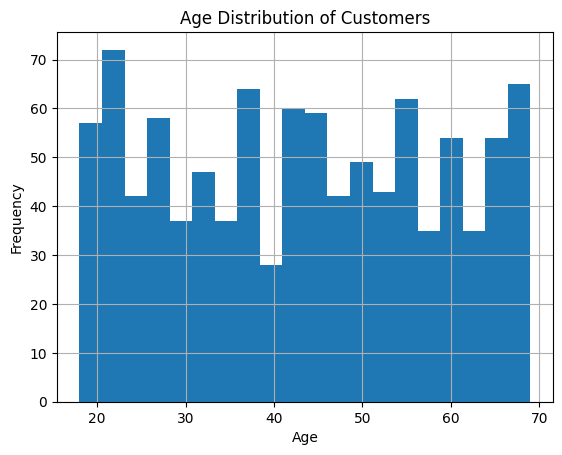

In [236]:
df['Age'].hist(bins=20)
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

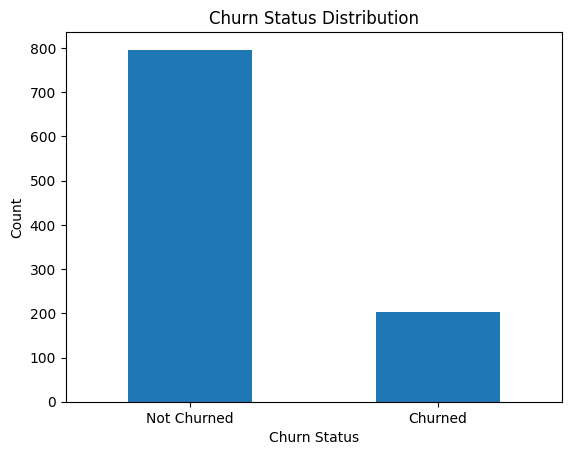

In [237]:
ax = df['ChurnStatus'].value_counts().plot(kind='bar')
ax.set_xticklabels(['Not Churned', 'Churned'], rotation=0)
plt.title('Churn Status Distribution')
plt.xlabel('Churn Status')
plt.ylabel('Count')

plt.show()


In [238]:
# this shows that total amount spent is not a good indicator of churn status
if 'TotalAmountSpent_Capped' in df_enc.columns and 'ChurnStatus' in df_enc.columns:
    fig = px.box(df_enc, x='ChurnStatus', y='TotalAmountSpent_Capped',
                    title='Total Amount Spent (Capped) by Churn Status',
                    labels={'ChurnStatus':'Churn Status (0=No,1=Yes)', 'TotalAmountSpent_Capped':'TotalAmountSpent (capped)'})
fig.show()

In [239]:
if all(c in df_enc.columns for c in ['RecencyDays', 'TotalAmountSpent_Capped', 'ChurnStatus']):
    fig = px.scatter(df_enc.sample(min(2000, len(df_enc))), x='RecencyDays', y='TotalAmountSpent_Capped',
                    color='ChurnStatus', title='Recency vs Total Amount Spent (sampled)')
fig.show()

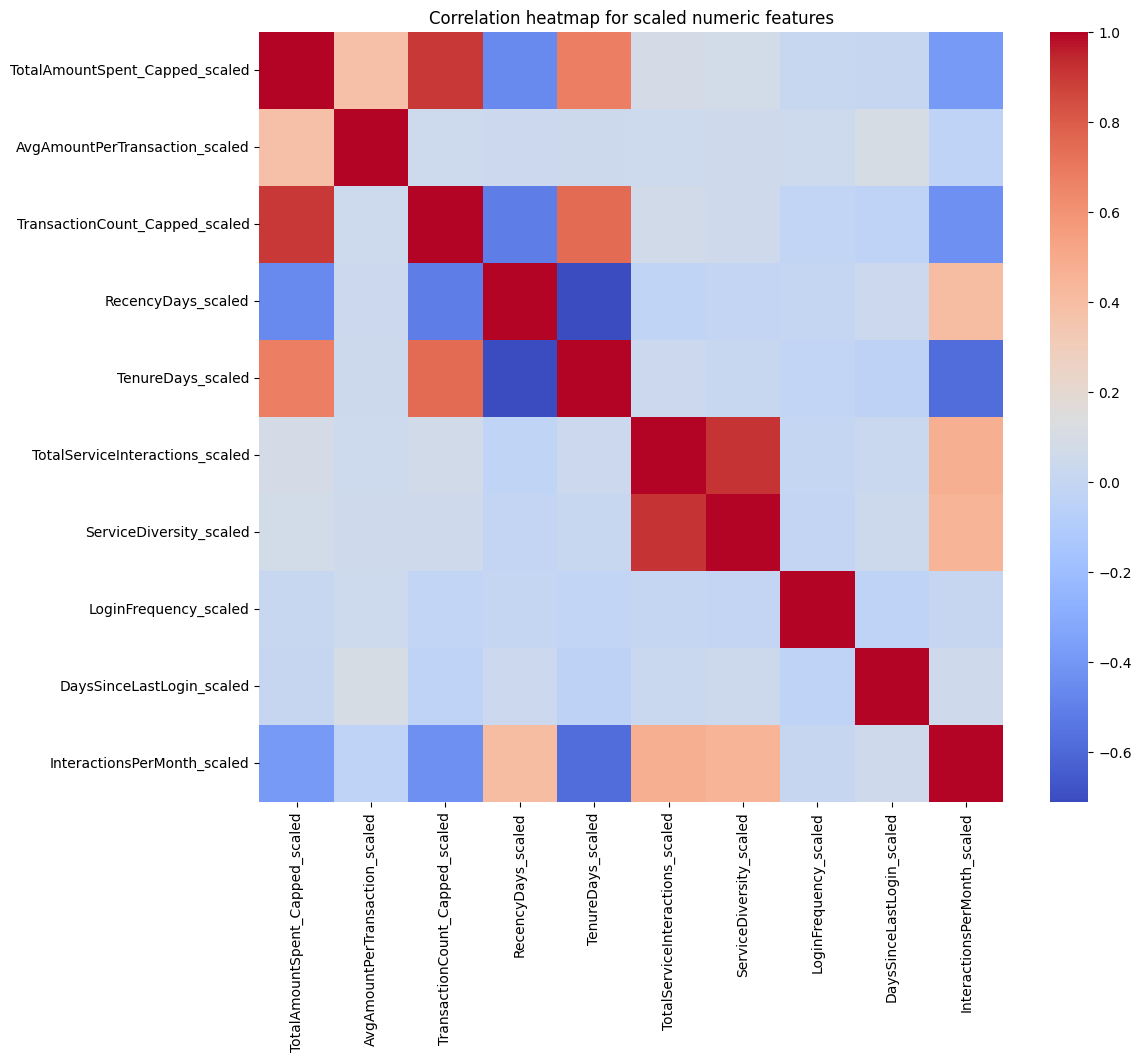

Preprocessing complete. You can now use the file for model training.


In [240]:
plt.figure(figsize=(12,10))
corr = df_enc[[c for c in df_enc.columns if c.endswith('_scaled')]].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation heatmap for scaled numeric features')
plt.show()

print("Preprocessing complete. You can now use the file for model training.")

In [241]:
df.to_csv('customer_churn_analysis_cleaned.csv', index=False)